# Flight delays

https://www.kaggle.com/usdot/flight-delays

### Description of data 

- YEAR, MONTH, DAY, DAY_OF_WEEK: dates of the flight 
- AIRLINE: An identification number assigned by US DOT to identify a unique airline 
- ORIGIN_AIRPORT and DESTINATION_AIRPORT: code attributed by IATA to identify the airports 
- SCHEDULED_DEPARTURE and SCHEDULED_ARRIVAL : scheduled times of take-off and landing 
- DEPARTURE_TIME and ARRIVAL_TIME: real times at which take-off and landing took place 
- DEPARTURE_DELAY and ARRIVAL_DELAY: difference (in minutes) between planned and real times 
- DISTANCE: distance (in miles) 

### Exercises

1. Create a date from : YEAR, MONTH, DAY to a datetime.date object
2. Convert SCHEDULED_DEPARTURE to a datetime.time object
3. Merge the airlines and the flights dataset
4. Find for each airline, the min, max, mean and count of DEPARTURE_DELAY 
5. How many airports ? How many airports are visited by each airline ?
6. What is the average delay by aiport ?
7. Average Delay by time of departure ?


In [70]:
import pandas as pd
import datetime as dt

import seaborn as sns

In [3]:
folder = '../datasets/flight-delays/'

airlines = pd.read_csv(folder + 'airlines.csv')
airports = pd.read_csv(folder + 'airports.csv')

In [6]:
flights = pd.read_csv(folder + 'flights.csv', nrows=1000000)

In [31]:
def create_date(x):
    return dt.date(x['YEAR'], x['MONTH'], x['DAY'])

In [34]:
flights['dafe'] = flights[['YEAR', 'MONTH', 'DAY']].apply(create_date, axis=1)

In [57]:
## 2. Convert SCHEDULED_DEPARTURE to a datetime.time object

def convert_time_old(x):
    if len(str(x)) == 1:
        return '000' + str(x)
    elif len(str(x)) == 2:
        return '00' + str(x)
    elif len(str(x)) == 3:
        return '0' + str(x)
    return str(x)

def convert_time(x):
    length = len(str(x))
    formatted = '0' * (4-length) + str(x)
    return dt.time(int(formatted[:2]), int(formatted[2:]))

flights['SCHEDULED_DEPARTURE_time'] = flights['SCHEDULED_DEPARTURE'].apply(convert_time)

In [67]:
# 7. Average Delay by time of departure ?
%matplotlib inline

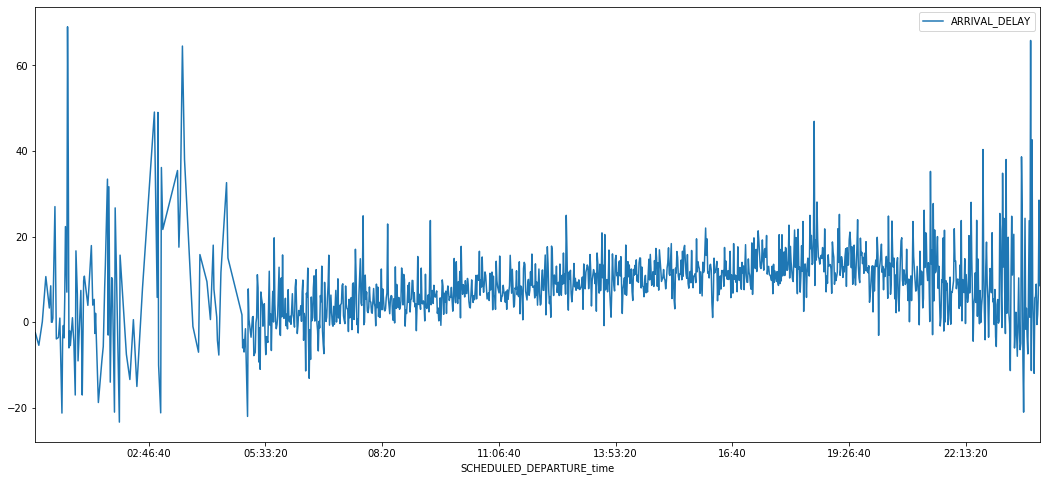

In [71]:
flights.groupby('SCHEDULED_DEPARTURE_time').agg({'ARRIVAL_DELAY': 'mean'}).plot(figsize=(18, 8))

flights[['SCHEDULED_DEPARTURE_time','ARRIVAL_DELAY']]

flights.groupby('SCHEDULED_DEPARTURE_time').agg({'ARRIVAL_DELAY': 'mean'})